# Benchmarking
## Bacterial dataset

In [8]:
import torch
import pandas as pd
import numpy as np
import json
import h5py
from pathlib import Path
from torch.utils.data import DataLoader
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from model.dataset import ToxDataset  # UPDATE THIS
from model.model_architecture import MLP     # UPDATE THIS

In [9]:
MODEL_PATH = "../model_output/protein_families/best_model.pt"
H5_FILE = "../benchmark/bacterial/bacterial.h5"
REFERENCE_CSV = "../data/interm/training_data.csv"  # Needed for label encoder
LABEL_COL = "Protein families"

In [10]:
ref_df = pd.read_csv(REFERENCE_CSV)
ref_dataset = ToxDataset(ref_df, [H5_FILE], is_train=True, label_col=LABEL_COL)
label_encoder = ref_dataset.le
ref_dataset.close()
print(f"Classes: {list(label_encoder.classes_)}")

Classes: ['Bradykinin-related peptide family', 'CRISP family', 'Cationic peptide family', 'Conotoxin family', 'Disintegrin family', 'Ergtoxin family', 'FARP (FMRFamide related peptide) family', 'Flavin monoamine oxidase family', 'Formicidae venom family', 'Insulin family', 'Limacoditoxin family', 'Long (3 C-C) scorpion toxin superfamily', 'Long (4 C-C) scorpion toxin superfamily', 'Long chain scorpion toxin family', 'MCD family', 'Natriuretic, Bradykinin potentiating peptide family', 'Neurotoxin family', 'Non-disulfide-bridged peptide (NDBP) superfamily', 'PDGF/VEGF growth factor family', 'Peptidase S1 family', 'Phospholipase family', 'Scoloptoxin family', 'Short scorpion toxin superfamily', 'Snaclec family', 'Teretoxin family', 'Three-finger toxin family', 'Vasopressin/oxytocin family', 'Venom Kunitz-type family', 'Venom metalloproteinase (M12B) family', 'nontox', 'other']


In [13]:
with h5py.File(H5_FILE, 'r') as f:
    sample_ids = list(f.keys())  # Get all top-level dataset names
    num_samples = len(sample_ids)

    # Optionally check the structure
    print(f"First few samples: {sample_ids[:5]}")
    # Check embedding shape from first sample
    first_sample = f[sample_ids[0]]
    print(f"Embedding shape for first sample: {first_sample.shape}")

print(f"Found {num_samples} samples in H5 file")

First few samples: ['A0A068QWU7', 'A0A068QYK9', 'A0A0A8J2Q4', 'A0A0C5XL88', 'A0A0C6PDA9']
Embedding shape for first sample: (1024,)
Found 10831 samples in H5 file


In [19]:
dummy_df = pd.DataFrame({
    'Entry': sample_ids,
    LABEL_COL: [label_encoder.classes_[0]] * num_samples  # dummy labels
})
dummy_df

,Entry,Protein families
0,A0A068QWU7,Bradykinin-related peptide family
1,A0A068QYK9,Bradykinin-related peptide family
2,A0A0A8J2Q4,Bradykinin-related peptide family
3,A0A0C5XL88,Bradykinin-related peptide family
4,A0A0C6PDA9,Bradykinin-related peptide family
...,...,...
10826,ZP_05940050.1,Bradykinin-related peptide family
10827,ZP_06208163.1,Bradykinin-related peptide family
10828,ZP_06481941.1,Bradykinin-related peptide family
10829,ZP_06486078.1,Bradykinin-related peptide family


In [20]:
inference_dataset = ToxDataset(
    dummy_df, [H5_FILE],
    label_encoder=label_encoder,
    is_train=False,
    label_col=LABEL_COL
)
inference_loader = DataLoader(inference_dataset, batch_size=64, shuffle=False)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Based on the error, your saved model has these dimensions:
model = MLP(
    input_dim=1024,   # From error: torch.Size([128, 1024])
    hidden_dim=128,   # From error: torch.Size([128])
    num_family_classes=31  # From error: torch.Size([31, 128])
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print(f"Model loaded on {device}")

Model loaded on cpu


In [22]:
print("Running inference...")
all_preds = []
all_probs = []

with torch.no_grad():
    for i, (features, _) in enumerate(inference_loader):
        features = features.to(device)
        outputs = model(features)

        # Get predictions and probabilities
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        if (i + 1) % 10 == 0:
            print(f"Processed {(i + 1) * 64} samples...")

print("Inference complete!")

Running inference...
Processed 640 samples...
Processed 1280 samples...
Processed 1920 samples...
Processed 2560 samples...
Processed 3200 samples...
Processed 3840 samples...
Processed 4480 samples...
Processed 5120 samples...
Processed 5760 samples...
Processed 6400 samples...
Processed 7040 samples...
Processed 7680 samples...
Processed 8320 samples...
Processed 8960 samples...
Processed 9600 samples...
Processed 10240 samples...
Processed 10880 samples...
Inference complete!


In [23]:
predicted_classes = [label_encoder.classes_[pred] for pred in all_preds]

# Create results dataframe
results_df = pd.DataFrame({
    'sample_id': sample_ids,
    'predicted_class': predicted_classes,
    'prediction_confidence': [max(prob) for prob in all_probs]
})

# Add probability columns for each class
for i, class_name in enumerate(label_encoder.classes_):
    results_df[f'prob_{class_name}'] = [prob[i] for prob in all_probs]

print(f"Results shape: {results_df.shape}")
results_df.head()

Results shape: (10831, 34)


,sample_id,predicted_class,prediction_confidence,prob_Bradykinin-related peptide family,prob_CRISP family,prob_Cationic peptide family,prob_Conotoxin family,prob_Disintegrin family,prob_Ergtoxin family,prob_FARP (FMRFamide related peptide) family,...,prob_Scoloptoxin family,prob_Short scorpion toxin superfamily,prob_Snaclec family,prob_Teretoxin family,prob_Three-finger toxin family,prob_Vasopressin/oxytocin family,prob_Venom Kunitz-type family,prob_Venom metalloproteinase (M12B) family,prob_nontox,prob_other
0,A0A068QWU7,nontox,0.937348,0.000046,0.000360,0.014887,0.000559,0.000369,0.000013,0.000198,...,0.007942,0.000040,0.000004,0.001714,0.000122,0.000598,0.000572,0.000583,0.937348,0.025665
1,A0A068QYK9,nontox,0.925493,0.000053,0.000384,0.016746,0.000718,0.000508,0.000016,0.000234,...,0.010843,0.000052,0.000005,0.002248,0.000142,0.000716,0.000682,0.000613,0.925493,0.030125
2,A0A0A8J2Q4,nontox,0.541996,0.000089,0.031600,0.002851,0.005608,0.002316,0.001078,0.000822,...,0.061337,0.002610,0.003587,0.020134,0.030494,0.015119,0.002698,0.003195,0.541996,0.154555
3,A0A0C5XL88,Phospholipase family,0.354413,0.000146,0.013014,0.005416,0.000613,0.001053,0.000451,0.001503,...,0.057009,0.000432,0.000377,0.004268,0.001958,0.011001,0.008316,0.004857,0.222878,0.237555
4,A0A0C6PDA9,nontox,0.834880,0.000414,0.000101,0.035079,0.006214,0.002966,0.000015,0.001562,...,0.048623,0.000041,0.000002,0.016513,0.000048,0.001485,0.000140,0.000135,0.834880,0.020500


In [24]:
class_counts = Counter(predicted_classes)
class_percentages = {cls: count/len(predicted_classes)*100
                    for cls, count in class_counts.items()}

confidences = [max(prob) for prob in all_probs]

stats = {
    'total_samples': len(predicted_classes),
    'class_distribution': {
        'counts': dict(class_counts),
        'percentages': class_percentages
    },
    'confidence_stats': {
        'mean_confidence': float(np.mean(confidences)),
        'median_confidence': float(np.median(confidences)),
        'min_confidence': float(np.min(confidences)),
        'max_confidence': float(np.max(confidences))
    }
}

print("Statistics calculated!")

Statistics calculated!


In [25]:
print(f"\n{'='*50}")
print(f"PREDICTION SUMMARY")
print(f"{'='*50}")
print(f"Total samples: {len(predicted_classes):,}")
print(f"Average confidence: {np.mean(confidences):.3f}")
print(f"Median confidence: {np.median(confidences):.3f}")

print(f"\nTop predicted classes:")
for cls, count in class_counts.most_common():
    pct = count/len(predicted_classes)*100
    print(f"  {cls}: {count:,} ({pct:.1f}%)")



PREDICTION SUMMARY
Total samples: 10,831
Average confidence: 0.793
Median confidence: 0.843

Top predicted classes:
  nontox: 10,564 (97.5%)
  Phospholipase family: 76 (0.7%)
  Venom metalloproteinase (M12B) family: 66 (0.6%)
  Scoloptoxin family: 50 (0.5%)
  other: 44 (0.4%)
  CRISP family: 10 (0.1%)
  Conotoxin family: 6 (0.1%)
  Neurotoxin family: 5 (0.0%)
  Formicidae venom family: 4 (0.0%)
  Peptidase S1 family: 3 (0.0%)
  Limacoditoxin family: 2 (0.0%)
  Non-disulfide-bridged peptide (NDBP) superfamily: 1 (0.0%)


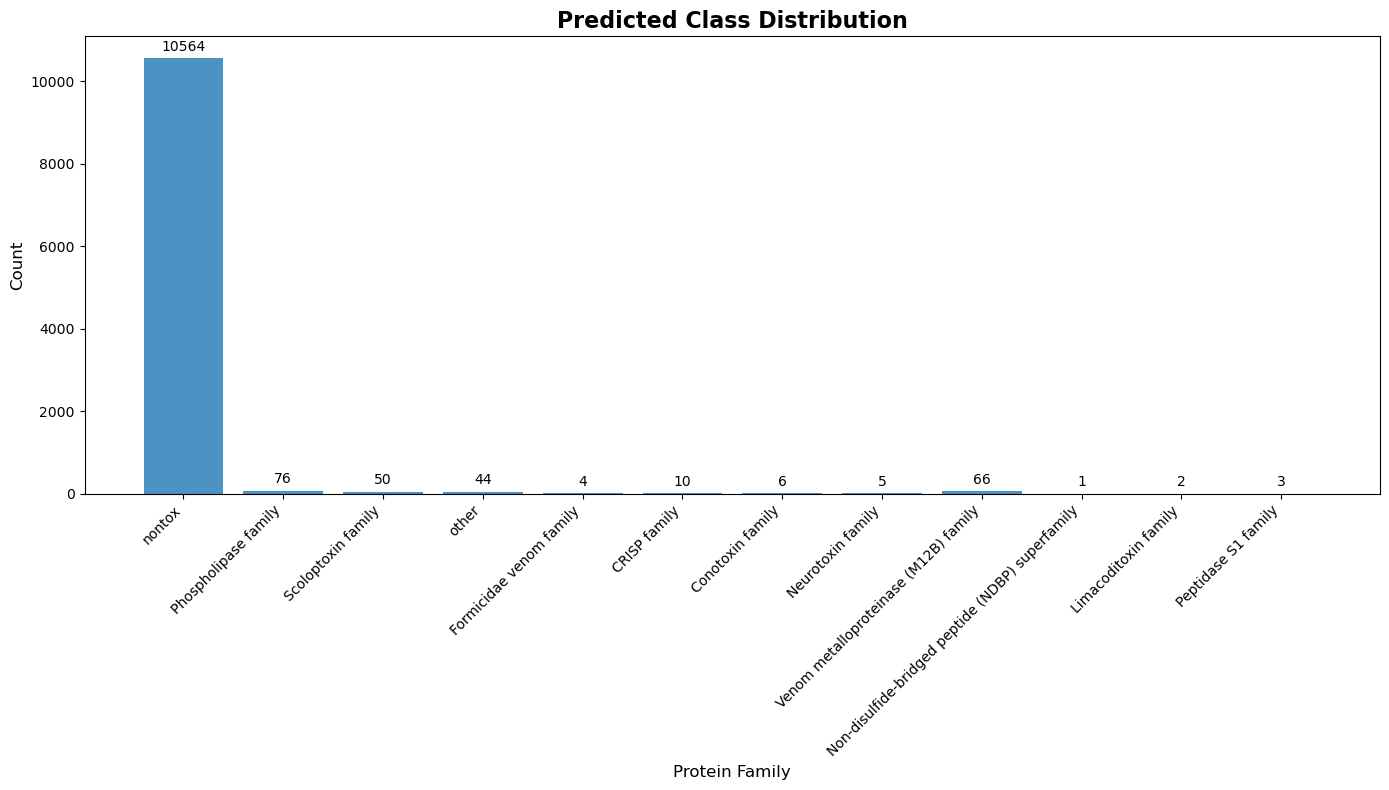

In [26]:
plt.figure(figsize=(14, 8))
classes = list(class_counts.keys())
counts = list(class_counts.values())

bars = plt.bar(classes, counts, alpha=0.8)
plt.title('Predicted Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Protein Family', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

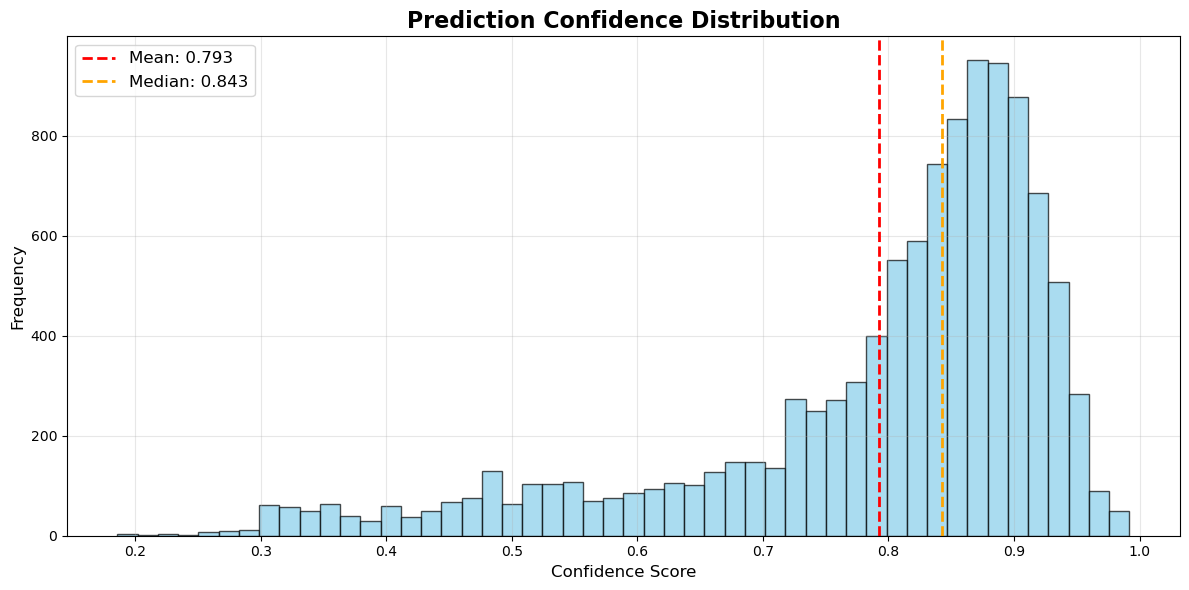

In [27]:
plt.figure(figsize=(12, 6))
plt.hist(confidences, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.title('Prediction Confidence Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(np.mean(confidences), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(confidences):.3f}')
plt.axvline(np.median(confidences), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {np.median(confidences):.3f}')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()